#### Import libraries

In [1]:
import numpy as np
import plotly.express as px
from plotly.io import write_image
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from IPython.display import Image

#### Initialize parameters

In [2]:
n = 10000 # number of samples
d = 1000 # number of dimensions
num_clusters = 10 # number of clusters
cutoff = 1000 # number of samples to use for the initial clustering

filtered_num_clusters = 5 # classes to use for initial clustering
extra_num_clusters = num_clusters - filtered_num_clusters

#### Generate data with all clusters

In [3]:
X, real_clusters = make_blobs(
    n_samples=n,
    n_features=d,
    centers=num_clusters,
    cluster_std=10,
    shuffle=True,
    random_state=42
    )

#### Filter initial clustering data (train) to selected clusters

In [4]:
real_train_clusters = real_clusters[:cutoff]
X_train = X[:cutoff]
X_test = X[cutoff:]

X_train = X_train[np.isin(real_train_clusters, range(filtered_num_clusters))]
real_train_clusters = real_train_clusters[np.isin(real_train_clusters, range(filtered_num_clusters))]

This results in X_train having only 3 clusters, while X_test keeps all 5 clusters.
This way X_test will have to introduce new clusters.

#### Agglomerative clustering

In [5]:
Z = linkage(X_train, 'ward')
train_clusters = fcluster(Z, filtered_num_clusters, criterion='maxclust')-1

#### Training KNN classifier on the cluster data to use for inference of test data

In [6]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, train_clusters)
test_clusters = knn.predict(X_test)

confusion_matrix(real_clusters[cutoff:], test_clusters)

array([[  0, 891,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 899,   0,   0,   0,   0,   0],
       [894,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 904,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 901,   0,   0,   0,   0,   0,   0],
       [135,  62, 533,  76, 100,   0,   0,   0,   0,   0],
       [133, 321, 158, 184, 119,   0,   0,   0,   0,   0],
       [117, 192, 201, 153, 241,   0,   0,   0,   0,   0],
       [197,  47, 349, 258,  52,   0,   0,   0,   0,   0],
       [168, 321, 261, 118,  15,   0,   0,   0,   0,   0]])

As the confusion matrix shows, the predicted classes overlap, and the 2 clusters that were not present in the training data are not predicted at all.

##### Calculate distance between test data and clusters

In [7]:
dists = knn.kneighbors(X_test, return_distance=True)[0].flatten()
dists.shape

(9000,)

#### Histogram of distances

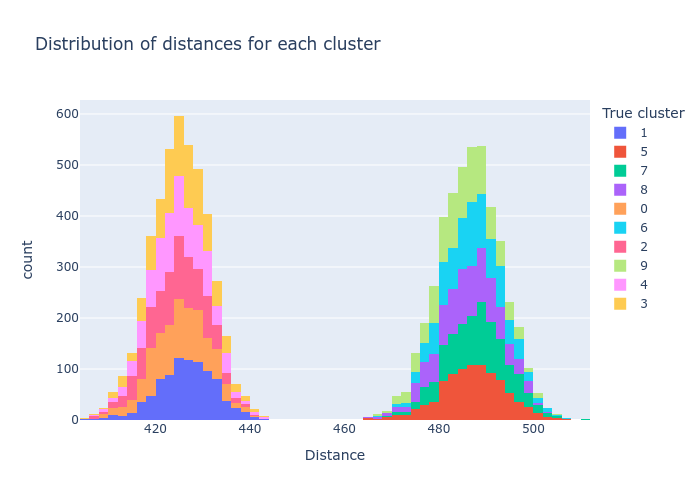

In [8]:
fig = px.histogram(
    x=dists,
    color=real_clusters[cutoff:],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distances for each cluster'
    )
write_image(fig, 'images/distance_distributions.png')
Image('images/distance_distributions.png')

As the histogram shows, the distances have normal distribution, but a very long right tail. We can't use outlier detection to separate the points that need new clusters. The threshold neither can be set to a fixed value, as it depends on the data and its dimensions, nor will it provide a perfect separation every time.

### Fit Gaussian Mixture Model to separate the points that need new clusters

In [9]:
gaussian = GaussianMixture(n_components=2, random_state=42)
gaussian.fit(dists.reshape(-1, 1))

probs = gaussian.predict_proba(dists.reshape(-1, 1))
assignments = np.argmax(probs, axis=1)

#### Get average distance of each group in ascending order

In [10]:
avg_dists = np.array([dists[assignments == i].mean() for i in range(2)])
smaller_avg_dist = np.argmin(avg_dists)
avg_dists

array([425.14139332, 486.60647221])

#### Plot average distance of each group

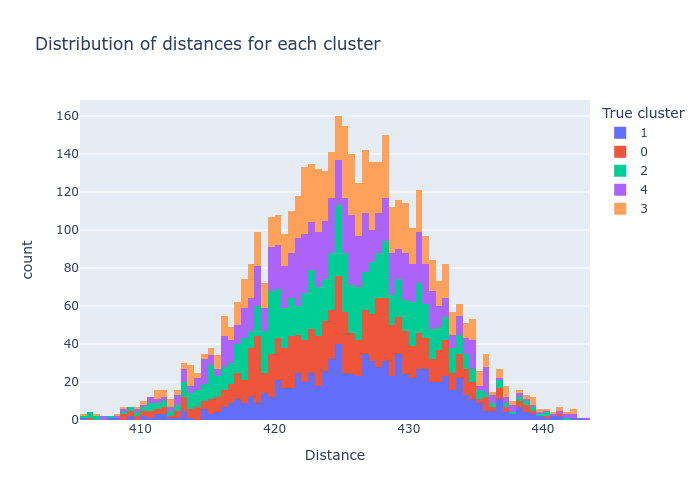

In [11]:
fig = px.histogram(
    x=dists[assignments==smaller_avg_dist],
    color=real_clusters[cutoff:][assignments==smaller_avg_dist],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distances for each cluster'
    )
write_image(fig, 'images/separated_group0.png')
Image(filename='images/separated_group0.png')

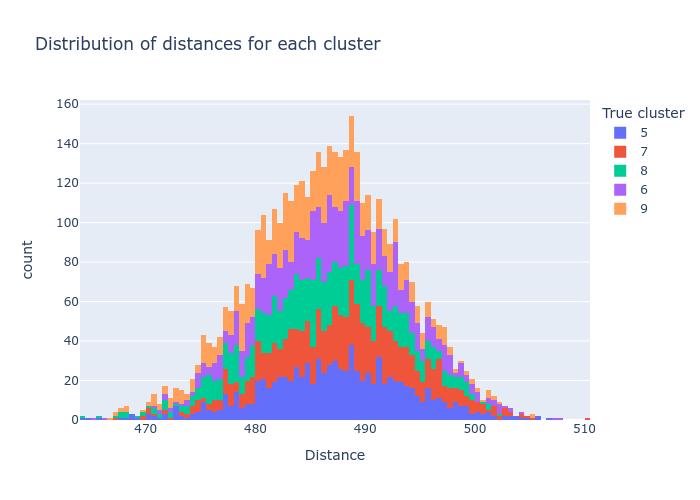

In [12]:
fig = px.histogram(
    x=dists[assignments!=smaller_avg_dist],
    color=real_clusters[cutoff:][assignments!=smaller_avg_dist],
    color_discrete_sequence=px.colors.qualitative.Plotly,
    barmode='stack',
    labels={'x':'Distance', 'color':'True cluster', 'value':'Count'},
    nbins=100,
    title='Distribution of distances for each cluster'
    )
write_image(fig, 'images/separated_group1.png')
Image(filename='images/separated_group1.png')


### Use the separation to cluster new data

In [13]:
X_test_to_classify = X_test[assignments==smaller_avg_dist]
test_to_classify_clusters = knn.predict(X_test_to_classify)
X_test_to_cluster = X_test[assignments!=smaller_avg_dist]
Z = linkage(X_test_to_cluster, 'ward')
test_to_cluster_clusters = fcluster(Z, extra_num_clusters, criterion='maxclust')-1

In [14]:
test_clusters = np.zeros(len(real_clusters[cutoff:]))
test_clusters[assignments==smaller_avg_dist] = test_to_classify_clusters
test_clusters[assignments!=smaller_avg_dist] = test_to_cluster_clusters + filtered_num_clusters
test_clusters = test_clusters.astype(int)

In [15]:
confusion_matrix(real_clusters[cutoff:], test_clusters)

array([[  0, 891,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 899,   0,   0,   0,   0,   0],
       [894,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 904,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 901,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 906,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 915,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 904],
       [  0,   0,   0,   0,   0,   0, 903,   0,   0,   0],
       [  0,   0,   0,   0,   0, 883,   0,   0,   0,   0]])